In [5]:
from altair import Axis, Bin, Chart, Color, expr, Order, Scale, SortField, X, Y
import pandas as pd

%matplotlib inline

In [26]:
COLORSCALE = ['#9ecae1', '#fdae6b', '#a1d99b', '#bcbddc', '#bdbdbd']
books = pd.read_csv('book-recommendations.csv', encoding='ISO-8859-1')

In [27]:
# Add additional columns to support grouping and plots later on
RACE_ETHNIC_GROUPS = ('Non-Hispanic white', 'People of color')

def group_name(sex, race, hispanic):
    if race == 'White' and hispanic == False:
        race_ethnicity = RACE_ETHNIC_GROUPS[0]
    else:
        race_ethnicity = RACE_ETHNIC_GROUPS[1]
    return '%s (%s)' % (race_ethnicity, 'men' if sex == 'Male' else 'women')

books['Demographic'] = books.apply(lambda x: group_name(x.Sex, x.Race, x.Hispanic), axis=1)
books['Race & Ethnic Category'] = (books['Race'] != 'White') | (books['Hispanic'] == True)
books['Race & Ethnic Category'] = books['Race & Ethnic Category'].map(
    lambda x: RACE_ETHNIC_GROUPS[1] if x else RACE_ETHNIC_GROUPS[0])
books['ApproxAge'] = books['Year'] - books['Born']


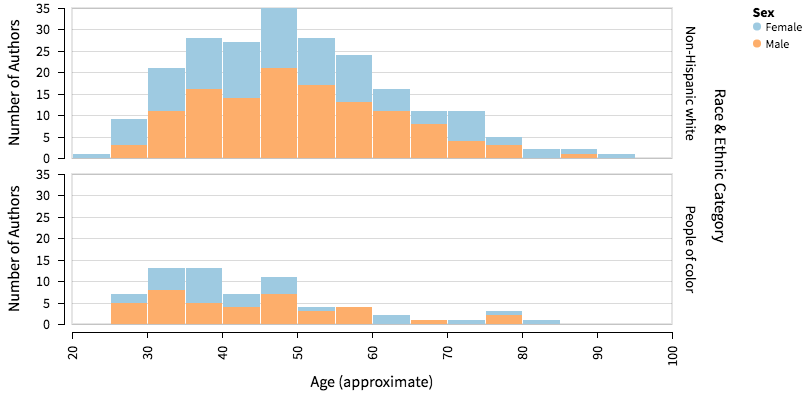

In [28]:
distinct_authors = books.drop_duplicates(subset=['First Author'])
Chart(distinct_authors[distinct_authors['Year'] ==  2016]).mark_bar() \
    .encode(
        X('ApproxAge', bin=Bin(maxbins=20), axis=Axis(title='Age (approximate)')),
        Y('count(*)', axis=Axis(title='Number of Authors')),
        row='Race & Ethnic Category',
        color=Color('Sex', scale=Scale(range=COLORSCALE))) \
    .transform_data(filter=expr.df.ApproxAge < 100) \
    .configure_cell(width=600, height=150) \
    .configure_axis(
        titleFontSize=16, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        tickPadding=8,
        titleOffset=50
    ) \
    .configure_facet_axis(
        titleFontSize=16, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        titleOffset=40
    ) \
    .configure_legend(
        labelFont='Source Sans Pro',
        labelFontSize=12,
        titleFont='Source Sans Pro',
        titleFontSize=14,
    )


In [29]:
# Average age by race & ethnic category
distinct_authors.groupby(['Race & Ethnic Category']).mean()['ApproxAge']

Race & Ethnic Category
Non-Hispanic white    49.920949
People of color       44.602740
Name: ApproxAge, dtype: float64

In [30]:
# Create a book_lists table that summarizes our data by list
publication = books.groupby(['Publication', 'Demographic']).count()['Title']
publication = publication \
    .unstack() \
    .fillna(0) \
    .reset_index()
    
publication['Total'] = (
    publication['People of color (men)'] 
  + publication['People of color (women)']
  + publication['Non-Hispanic white (men)'] 
  + publication['Non-Hispanic white (women)']
)

publication['Percent people of color'] = 100 * (
    publication['People of color (men)'] + publication['People of color (women)']) / publication['Total']
publication['Percent women'] = 100 * (
    publication['People of color (women)'] + publication['Non-Hispanic white (women)']) / publication['Total']

categories_by_publication = books.groupby(['Publication', 'Category'])['Title'].count().unstack().fillna(0)
publication = publication.join(categories_by_publication, on='Publication')
publication['Percent fiction'] = 100 * publication['Fiction'] / publication['Total']
publication.head()

,Publication,Non-Hispanic white (men),Non-Hispanic white (women),People of color (men),People of color (women),Total,Percent people of color,Percent women,Fiction,Non-Fiction,Percent fiction
0,Bill Gates,3.0,1.0,1.0,0.0,5.0,20.000000,20.000000,0.0,5.0,0.000000
1,Boston Globe,33.0,26.0,16.0,7.0,82.0,28.048780,40.243902,47.0,35.0,57.317073
2,Brain Pickings,5.0,9.0,1.0,1.0,16.0,12.500000,62.500000,2.0,14.0,12.500000
3,Buzzfeed,12.0,9.0,9.0,12.0,42.0,50.000000,50.000000,24.0,18.0,57.142857
4,Economist,31.0,9.0,8.0,4.0,52.0,23.076923,25.000000,5.0,47.0,9.615385


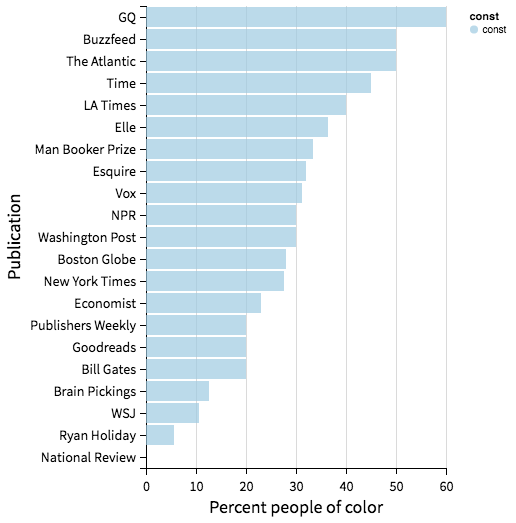

In [37]:
# Percent POC authors by book list
publication['const'] = 'const' # Hack to set color w/o facets. (What's the proper way?)
Chart(publication.sort_values('Percent people of color', ascending=False)).mark_bar() \
    .encode(
        Y('Publication', sort=SortField('Percent POC authors')), 
        X('Percent people of color'),
        color=Color('const', scale=Scale(range=COLORSCALE))) \
    .configure_cell(width=300, height=200) \
    .configure_axis(
        titleFontSize=18, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        tickPadding=4,
    )

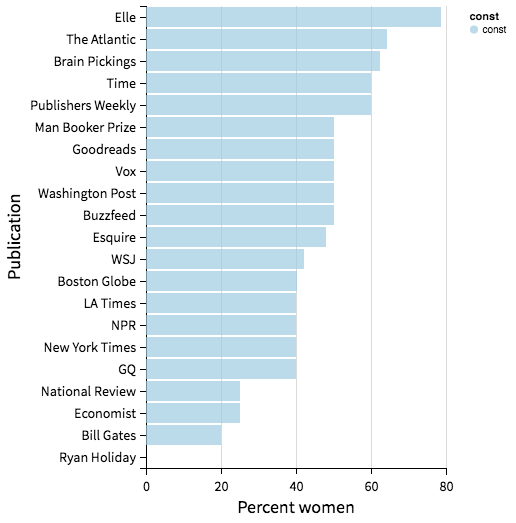

In [38]:
# Percent female authors by book list
# TODO: Figure out correct way to sort. Clearly this is redundant.
Chart(publication.sort_values('Percent women', ascending=False)).mark_bar() \
    .encode(
        y=Y('Publication', sort=SortField(field='Percent women', order='ascending')), 
        x=X('Percent women'),
        color=Color('const', scale=Scale(range=COLORSCALE))) \
    .configure_cell(width=300, height=200) \
    .configure_axis(
        titleFontSize=18, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        tickPadding=4,
    )


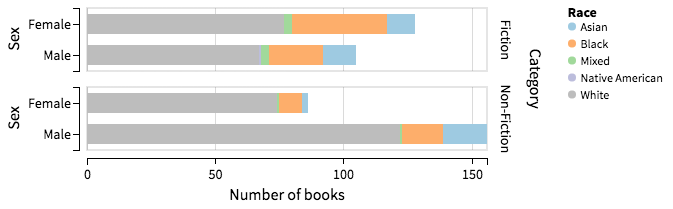

In [33]:
# Representation in fiction vs non-fiction
Chart(books).mark_bar() \
    .encode(
        Y('Sex'),
        X('count(*)', axis=Axis(title='Number of books')),
        color=Color('Race', scale=Scale(range=COLORSCALE)),
        row='Category') \
    .configure_cell(width=400, height=400) \
    .configure_axis(
        titleFontSize=16, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        tickPadding=2,
    ) \
    .configure_facet_axis(
        titleFontSize=16, 
        titleFont='Source Sans Pro', 
        tickLabelFont='Source Sans Pro', 
        tickLabelFontSize=14,
        titleFontWeight='normal',
        titleOffset=40
    ) \
    .configure_legend(
        labelFont='Source Sans Pro',
        labelFontSize=12,
        titleFont='Source Sans Pro',
        titleFontSize=14,
    )